In [120]:
import pandas as pd
import numpy as np
import math
from scipy.stats import weibull_min, invweibull, uniform, norm, multivariate_normal
from scipy.interpolate import interp1d
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from pylab import rcParams

import seaborn as sns

import helpers

sns.set()

rcParams['figure.figsize'] = 20,20

# Create the P function from matlab
data = np.loadtxt("powermat.csv", delimiter=",")
x = np.arange(0,30,0.001)
P = interp1d(x,data, fill_value="extrapolate")

# Creating lambda function allowing faster calculations
calculate_power = lambda x: P(x)
#_ = plt.plot(x,P(x))

n = 10**5

hlp = helpers.helper_methods(n)
hlp.init_winds()

# 2 a)

\begin{tabular}{lllr}
\toprule
{} &        Mean &    Interval &      Variance \\
Month &             &             &               \\
\midrule
jan   &  1726728.94 &  ± 24052.35 &  1.505923e+12 \\
feb   &  1565347.07 &  ± 23846.75 &  1.480288e+12 \\
mar   &  1479653.94 &  ± 23581.54 &  1.447546e+12 \\
apr   &   1187975.6 &  ± 22407.34 &  1.306978e+12 \\
may   &  1141027.51 &   ± 22101.0 &  1.271487e+12 \\
jun   &  1210158.37 &  ± 22648.76 &  1.335294e+12 \\
jul   &  1133656.06 &  ± 21867.91 &  1.244808e+12 \\
aug   &  1197279.45 &  ± 22663.41 &  1.337022e+12 \\
sep   &  1441601.67 &  ± 23461.71 &  1.432871e+12 \\
oct   &  1587896.07 &  ± 24158.23 &  1.519211e+12 \\
nov   &  1724443.95 &   ± 24000.4 &  1.499425e+12 \\
dec   &  1720291.56 &  ± 23962.91 &  1.494744e+12 \\
\bottomrule
\end{tabular}



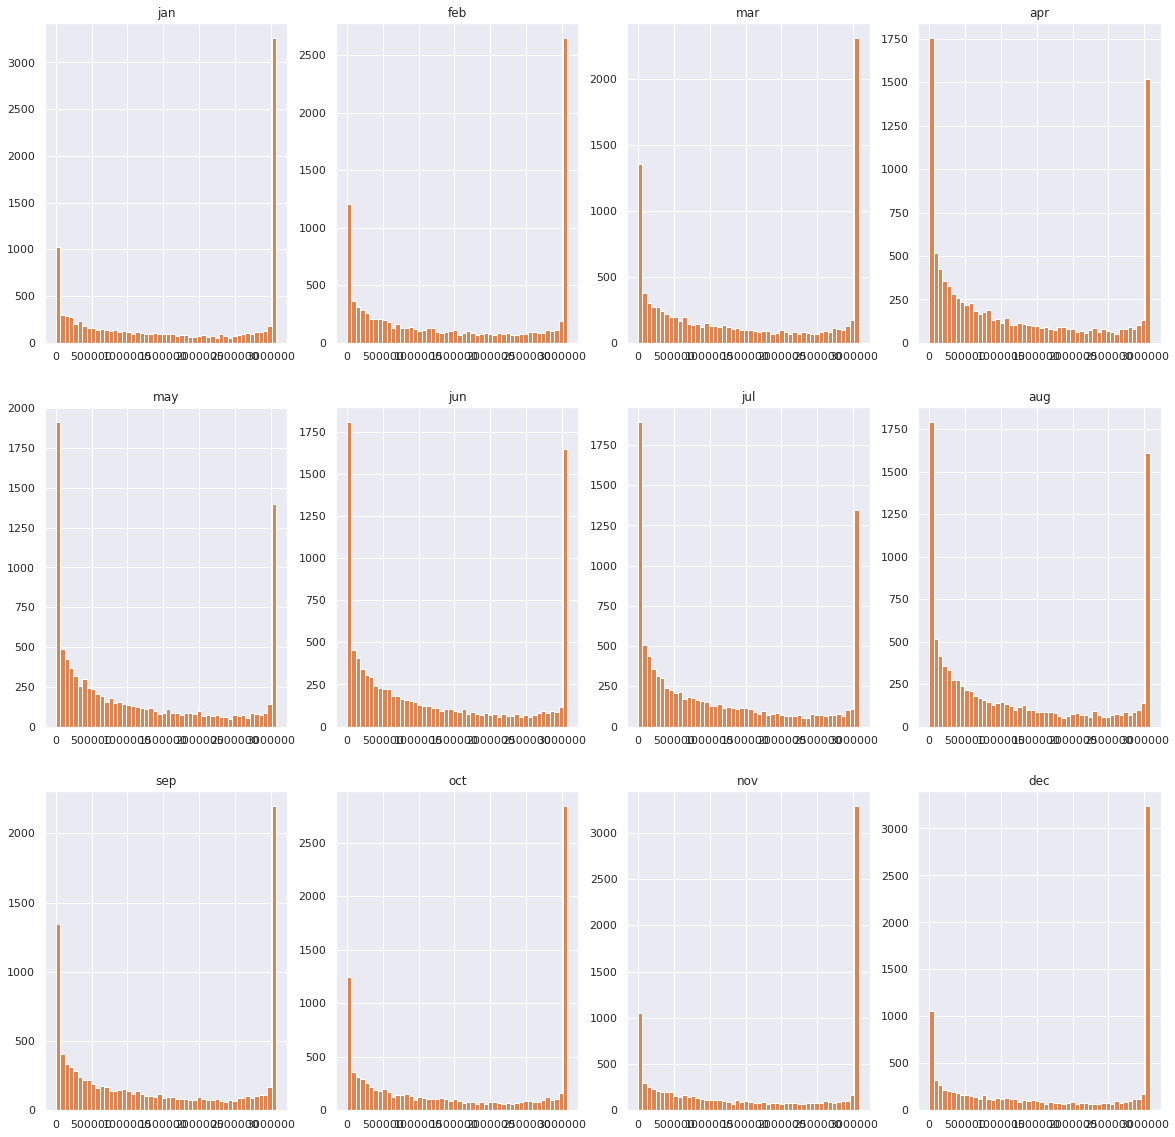

In [14]:
# A) Expected amount of power
i = 1
result = []

for key, wind in hlp.winds.items():

    # Plotting
    plt.subplot(3,4,i)
    i+=1
    plt.hist(wind["wind"], bins=100, density=True)
    plt.gca().set_title(key)

    # Calculated power from the generated wind
    power = P(wind["wind"])
    hist = plt.hist(power, bins=50)

    # Calculating mean, variance and the confidence interval for the mean
    mean = np.mean(power)
    var = np.var(power)
    confidence_interval = 1.96*np.sqrt(var/n)
    
    result.append({"Month" : key, "Mean": f'{np.round(mean, decimals = 2)}',
                   "Interval": f'± {np.round(confidence_interval, decimals=2)}',
                    "Variance": np.round(var, decimals=2)})
    
print(pd.DataFrame(result).set_index(keys="Month").to_latex())

# 2 a) Truncated U

\begin{tabular}{lllr}
\toprule
{} &        Mean &    Interval &      Variance \\
Month &             &             &               \\
\midrule
jan   &  1752466.17 &   ± 20864.8 &  1.133226e+12 \\
feb   &  1562526.57 &   ± 20489.9 &  1.092867e+12 \\
mar   &  1481522.33 &   ± 20398.7 &  1.083161e+12 \\
apr   &  1189823.14 &  ± 18751.97 &  9.153386e+11 \\
may   &  1142972.49 &  ± 18343.86 &  8.759300e+11 \\
jun   &  1197250.28 &  ± 18914.84 &  9.313080e+11 \\
jul   &  1149435.11 &  ± 18482.42 &  8.892129e+11 \\
aug   &  1203772.49 &  ± 18934.98 &  9.332924e+11 \\
sep   &  1433163.46 &  ± 20250.48 &  1.067477e+12 \\
oct   &  1602881.27 &  ± 20498.98 &  1.093837e+12 \\
nov   &  1726197.93 &  ± 21032.18 &  1.151480e+12 \\
dec   &  1724777.74 &  ± 20897.06 &  1.136732e+12 \\
\bottomrule
\end{tabular}



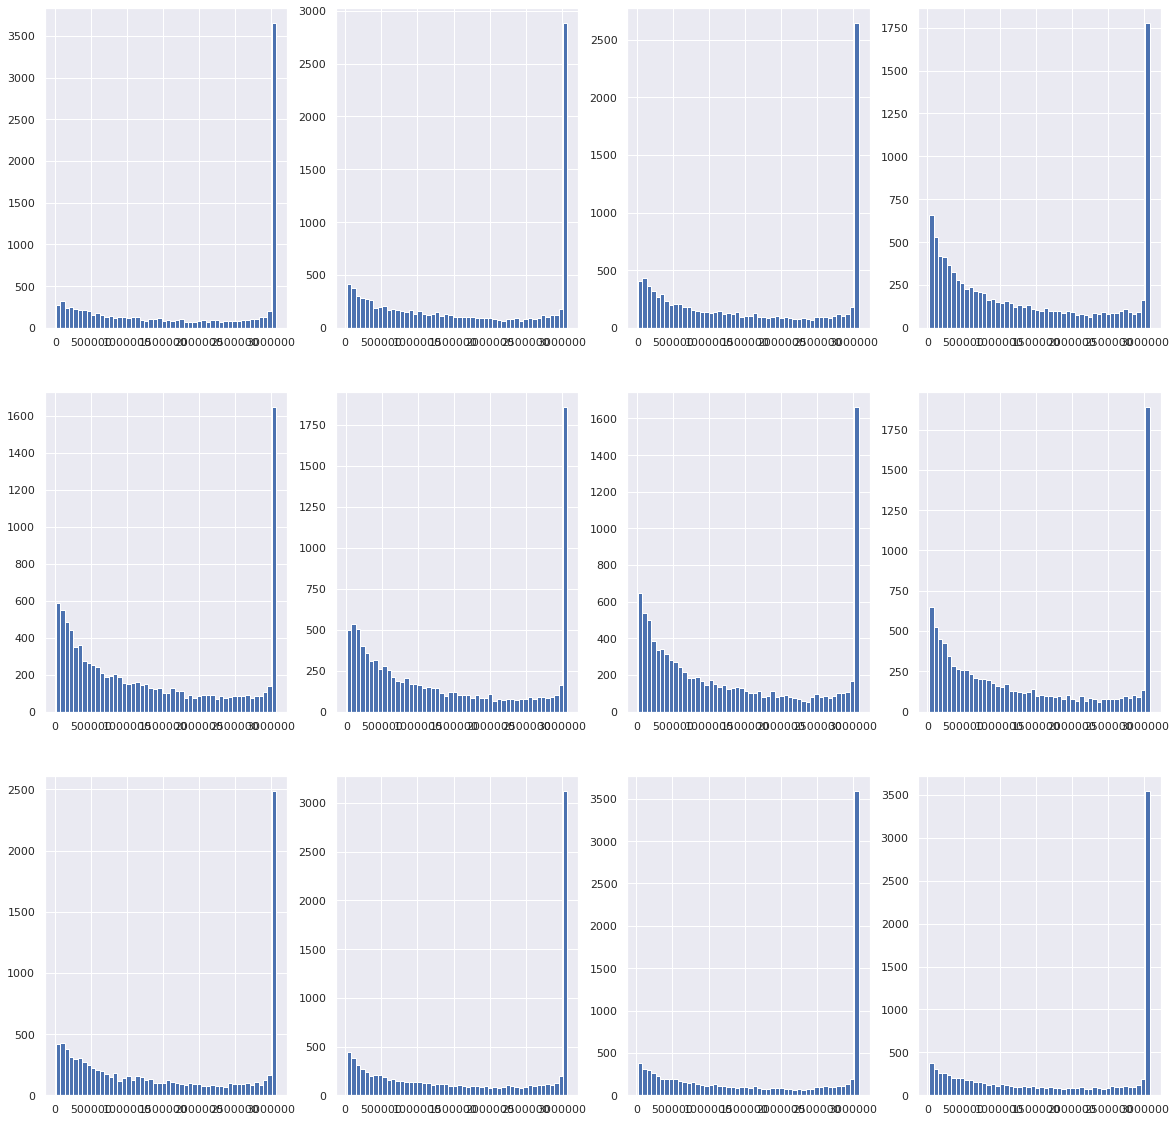

In [15]:
# A) Expected amount of power, truncated version
i = 1

result = []

for key, wind in hlp.winds.items():

    # Calculating F(3) and F(25) for the distribution for the wind
    F_min = wind["dist"].cdf(3)
    F_max = wind["dist"].cdf(25)

    # Generate uniform data
    u = uniform.rvs(size=n)

    # Fix condition to U
    u = ((F_max-F_min)*u + F_min)

    # Run u through inverse of weibull 
    wind_truncated = wind["dist"].ppf(u)

    # Calculated the power for the truncated wind
    power_trunc = calculate_power(wind_truncated)

    plt.subplot(3,4,i)
    i+=1
    hist = plt.hist(power_trunc, bins=50)

    # Calculating mean, variance and the confidence interval for the mean
    mean = np.mean(power_trunc)*(F_max-F_min)
    var = np.var(power_trunc)*((F_max-F_min)**2)
    confidence_interval = 1.96*np.sqrt(var/n)

    result.append({"Month" : key, "Mean": f'{np.round(mean, decimals = 2)}',
                   "Interval": f'± {np.round(confidence_interval, decimals=2)}',
                    "Variance": np.round(var, decimals=2)})
    
print(pd.DataFrame(result).set_index(keys="Month").to_latex())

# 2 b) Importance Sampling

\begin{tabular}{lllr}
\toprule
{} &        Mean &   Interval &      Variance \\
Month &             &            &               \\
\midrule
jan   &   1724549.0 &  ± 9734.07 &  2.466473e+11 \\
feb   &  1558025.07 &  ± 8412.92 &  1.842391e+11 \\
mar   &  1471845.72 &  ± 8197.25 &  1.749138e+11 \\
apr   &  1190415.29 &  ± 7881.92 &  1.617155e+11 \\
may   &  1139981.65 &   ± 7595.7 &  1.501838e+11 \\
jun   &  1213076.99 &  ± 7890.87 &  1.620830e+11 \\
jul   &  1144071.27 &  ± 7526.87 &  1.474744e+11 \\
aug   &  1209826.97 &  ± 7969.81 &  1.653424e+11 \\
sep   &  1445260.18 &  ± 7930.44 &  1.637126e+11 \\
oct   &  1590112.77 &  ± 8584.73 &  1.918407e+11 \\
nov   &  1731899.16 &  ± 9507.24 &  2.352863e+11 \\
dec   &  1726819.17 &  ± 9759.01 &  2.479130e+11 \\
\bottomrule
\end{tabular}



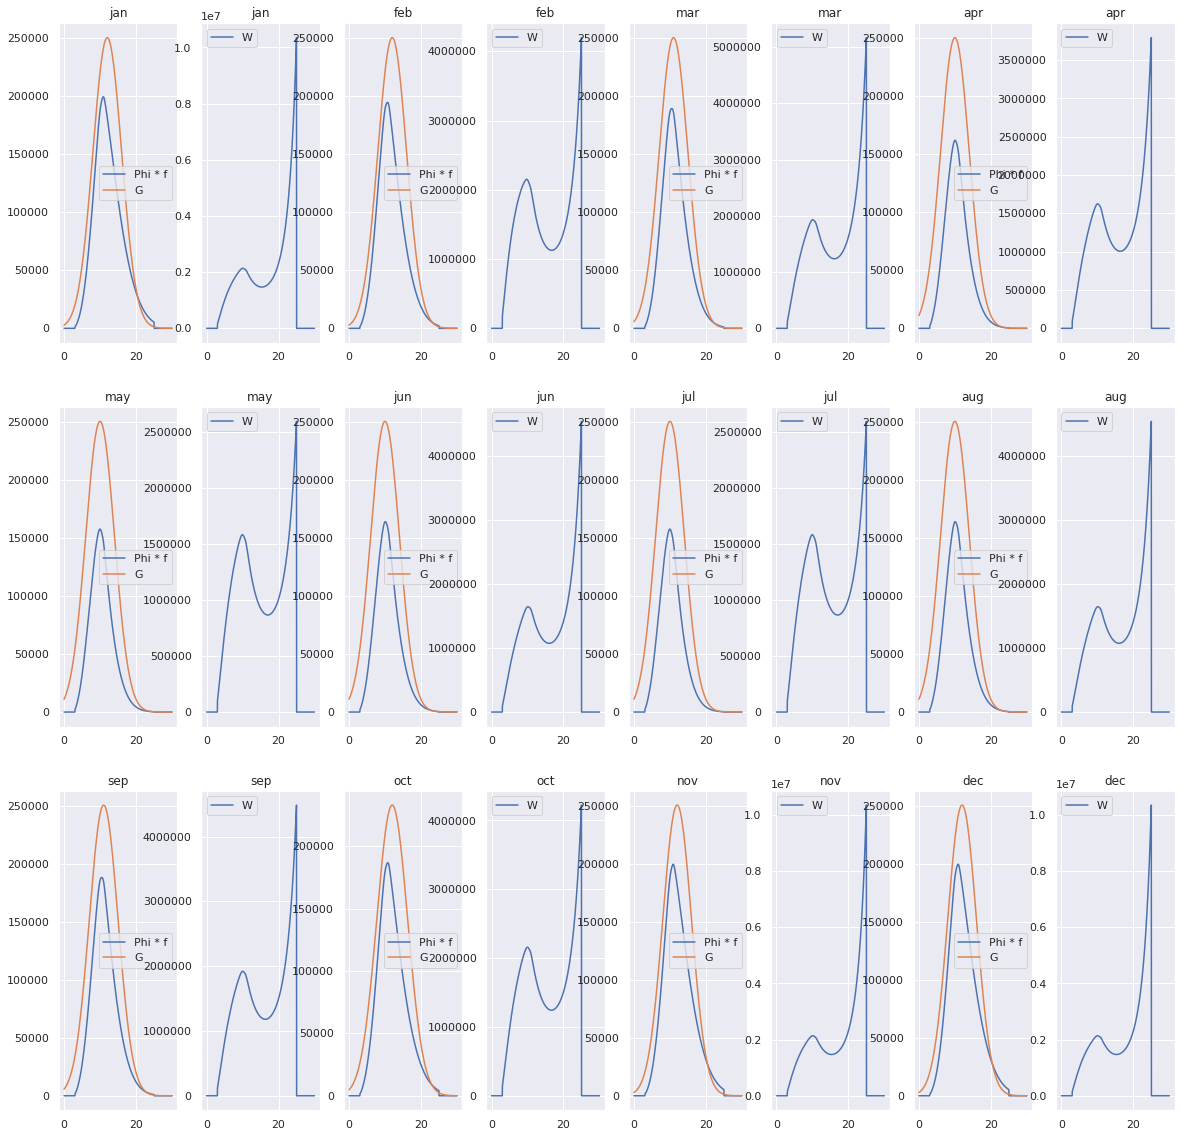

In [16]:
x = np.linspace(0,30, num=n)
i = 1
result = []

g_parameters  = {
        "jan" : [12, 4],
        "feb" : [12, 4],
        "mar" : [11, 4],
        "apr" : [10, 4],
        "may" : [10, 4],
        "jun" : [10, 4],
        "jul" : [10, 4],
        "aug" : [10, 4],
        "sep" : [11, 4],
        "oct" : [12, 4.3],
        "nov" : [12, 4],
        "dec" : [12, 4]
    }

for key, wind in hlp.winds.items():

    h = lambda x: P(x)*wind["dist"].pdf(x)

    # Selecting g as a normal distribution
    my = g_parameters[key][0]
    sigma2 = g_parameters[key][1]
    g_scale = 10**6.4
    g_dist = norm(my, sigma2)
    g = lambda x: g_dist.pdf(x)
    
    plt.subplot(3,8,i)
    
    i+=1
    plt.plot(x, h(x), label="Phi * f")
    plt.plot(x, g(x)*g_scale, label="G")
    plt.legend()
    plt.gca().set_title(key)

    plt.subplot(3,8,i)
    i+=1
    plt.plot(x, h(x)/g(x), label="W")
    plt.gca().set_title(key)
    plt.legend()

    X = g_dist.rvs(size=n)

    # Function to evaluate
    s = lambda x: h(x)/g(x)

    # Calculate variance
    mean = np.mean(s(X))
    var = np.var(s(X))
    confidence_interval = 1.96*np.sqrt(var/n)
    
    result.append({"Month" : key, "Mean": f'{np.round(mean, decimals = 2)}',
                   "Interval": f'± {np.round(confidence_interval, decimals=2)}',
                    "Variance": np.round(var, decimals=2)})
    
print(pd.DataFrame(result).set_index(keys="Month").to_latex())

# 2 c) Antithetic sampling

\begin{tabular}{lllr}
\toprule
{} &        Mean &   Interval &      Variance \\
Month &             &            &               \\
\midrule
jan   &  1734628.28 &  ± 3817.72 &  3.793991e+10 \\
feb   &  1569802.77 &  ± 1677.99 &  7.329360e+09 \\
mar   &  1469069.73 &  ± 1420.37 &  5.251569e+09 \\
apr   &   1187017.8 &  ± 3575.77 &  3.328327e+10 \\
may   &  1139337.64 &  ± 3950.58 &  4.062657e+10 \\
jun   &  1211524.24 &  ± 3393.53 &  2.997716e+10 \\
jul   &  1140699.45 &   ± 3953.3 &  4.068242e+10 \\
aug   &  1213584.22 &   ± 3366.4 &  2.949988e+10 \\
sep   &  1447162.47 &  ± 1536.61 &  6.146306e+09 \\
oct   &  1586522.76 &  ± 2093.64 &  1.141017e+10 \\
nov   &  1735184.02 &  ± 3838.32 &  3.835044e+10 \\
dec   &  1730355.73 &  ± 3849.86 &  3.858128e+10 \\
\bottomrule
\end{tabular}



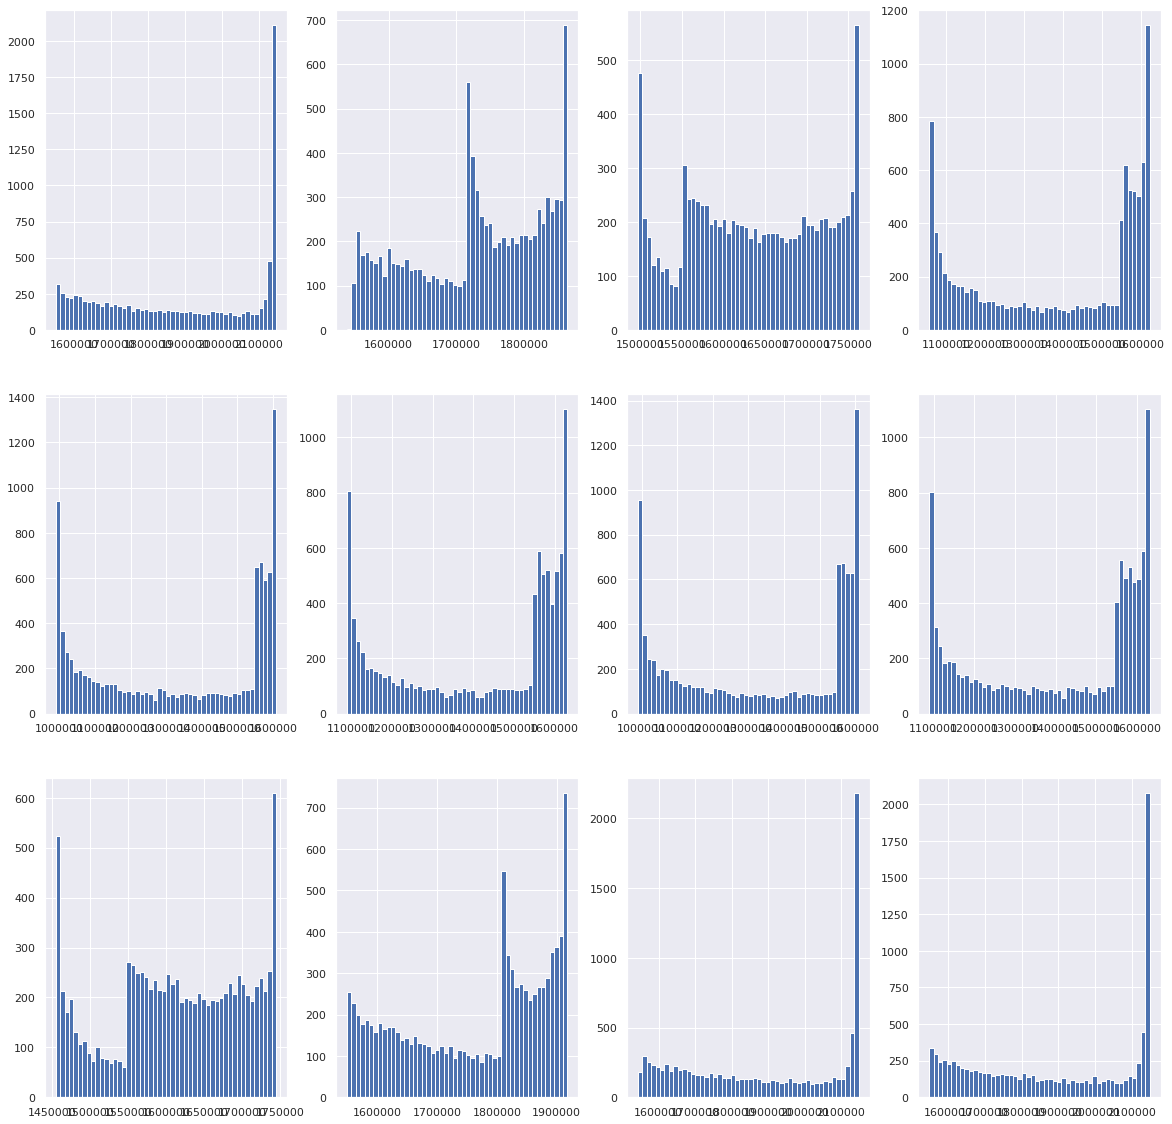

In [17]:
# A) Expected amount of power, truncated version
i = 1
result = []

for key, wind in hlp.winds.items():

    # Calculating F(3) and F(25) for the distribution for the wind
    F_min = wind["dist"].cdf(3)
    F_max = wind["dist"].cdf(25)

    # Generate uniform data
    u = uniform.rvs(size=n)
    u2 = 1 - u

    # Fix condition to U
    u = ((F_max-F_min)*u + F_min)
    u2 = ((F_max-F_min)*u2 + F_min)

    # Run u through inverse of weibull
    v = P(wind["dist"].ppf(u))
    v2 = P(wind["dist"].ppf(u2))
    
    # Calculated the power for the truncated wind
    w = (v + v2)/2

    plt.subplot(3,4,i)
    i+=1
    hist = plt.hist(w, bins=50)

    # Calculating mean, variance and the confidence interval for the mean
    mean = np.mean(w)*(F_max-F_min)
    var = np.var(w)*((F_max-F_min)**2)
    confidence_interval = 1.96*np.sqrt(var/n)

    result.append({"Month" : key, "Mean": f'{np.round(mean, decimals = 2)}',
                   "Interval": f'± {np.round(confidence_interval, decimals=2)}',
                    "Variance": np.round(var, decimals=2)})
    
print(pd.DataFrame(result).set_index(keys="Month").to_latex())

# 2 d)

In [18]:
# Probability that the turbine delivers power
print(f'Prob for delivering power: {(F_max - F_min)*100}%')

Prob for delivering power: 91.91850832071029%


# 2 e) Estimating power ratio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning:

invalid value encountered in true_divide



NameError: name 'power_ratio' is not defined

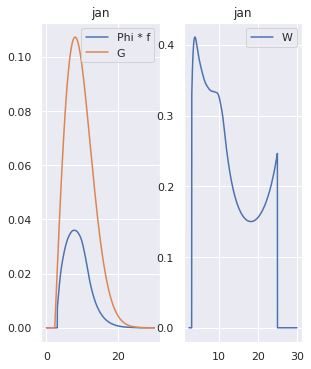

In [19]:
Ptot = lambda v: 1/2*1.225*math.pi*112**2/4*v**3
x = np.linspace(0,30, num=n)

i = 1

result = []

g_parameters  = {
        "jan" : [8, 2, 2.3],
        "feb" : [8, 2, 2.3],
        "mar" : [8, 2, 2.3],
        "apr" : [8, 2, 2.3],
        "may" : [8, 2, 2.3],
        "jun" : [8, 2, 2.3],
        "jul" : [8, 2, 2.3],
        "aug" : [8, 2, 2.3],
        "sep" : [8, 2, 2.3],
        "oct" : [8, 2, 2.3],
        "nov" : [8, 2, 2.3],
        "dec" : [8, 2, 2.3],
    }

for key, wind in hlp.winds.items():
        
    h = lambda x: P(x)/Ptot(x)*wind["dist"].pdf(x)

    # Selecting g as a weibull distribution
    g_dist_lambda = g_parameters[key][0] 
    g_dist_k = g_parameters[key][1] 
    loc = g_parameters[key][2] 
    
    g_dist = weibull_min(g_dist_k, loc = loc, scale = g_dist_lambda)
    g = lambda x: g_dist.pdf(x)

    plt.subplot(3,8,i)
    
    i+=1
    plt.plot(x, h(x), label="Phi * f")
    plt.plot(x, g(x), label="G")
    plt.legend()
    plt.gca().set_title(key)

    plt.subplot(3,8,i)
    i+=1
    plt.plot(x, h(x)/g(x), label="W")
    plt.gca().set_title(key)
    plt.legend()

    plt.plot(x, wind["dist"].pdf(x)*power_ratio(x)/g(x))

    X = g_dist.rvs(size=n)

    # Function to evaluate
    s = lambda x: h(x)/g(x)
    sample = s(X)
    
    # Calculate variance
    mean = np.mean(sample)
    var = np.var(sample)
    confidence_interval = 1.96*np.sqrt(var/n)

    result.append({"Month" : key, "Mean": f'{np.round(mean, decimals = 5)} ± {np.round(confidence_interval, decimals=5)}'})
    
print(pd.DataFrame(result).set_index(keys="Month").to_latex())

# Uppgift 3

In [260]:
# Selecting the appropiate disitribvtions
# Uppgift 3
# A
k = 1.96
lamda = 9.13

# Creating the marginal wind distribution
wind_distribution =  weibull_min(k,loc=0, scale=lamda)

# Constants
a = 0.638
p = 3
q = 1.5

# Multivariate densyty function
f = lambda v1, v2: wind_distribution.pdf(v1)*wind_distribution.pdf(v2)*(1+a*(1-wind_distribution.cdf(v1)**p)**(q-1)
                          *(1-wind_distribution.cdf(v2)**p)**(q-1)
                          *(wind_distribution.cdf(v1)**p*(1+p*q)-1)
                          *(wind_distribution.cdf(v2)**p*(1+p*q)-1))


# Selecting g as a multivariate normal distribution
mean = [12, 12] 
matrix = [[6, 1], [1, 6]] 
g_dist_multi = multivariate_normal(mean, matrix)
g_dist_normal = norm(mean[0], matrix[0][0])

x = np.linspace(0,30,60)
y = np.linspace(0,30,60)

x, y = np.meshgrid(x, y)
pos = np.dstack((x, y))

scale_constant = 5*10**12

fig = go.Figure(data=[go.Surface(z=f(x,y)*P(x)*P(y), x=x, y=y), 
                      go.Surface(z=scale_constant*g_dist_multi.pdf(pos), x=x, y=y, colorscale='Blues', opacity=0.5)])

fig.update_layout(title='Mt Bruno Elevation', autosize=True,
                  width=800, height=500)

fig.show()

In [370]:
# Drag n samples
bivariate_samples = g_dist_multi.rvs(n)

# Creating two seperate winds
v1 = P(wind_distribution.rvs(n))
v2 = P(wind_distribution.rvs(n))

# Generate P(V1) and P(V2)
G1 = bivariate_samples.transpose()[0]
G2 = bivariate_samples.transpose()[1]

# Vectorizing for speed
samples_cov = P(G1)*P(G2)*f(G1,G2)/g_dist_multi.pdf(bivariate_samples)

sample_sum = (P(G1)+P(G2))*f(G1,G2)/g_dist_multi.pdf(bivariate_samples)

# Mean in task A)
mean = np.mean(v1)+np.mean(v2)

# Calculate covariance task B)
cov = np.mean(samples_cov) - np.mean(v1)*np.mean(v2)

# Calculate variance in task C)
var = np.var(v1)+np.var(v2)+2*cov

# Calculate std in task C)
std = np.sqrt(var)

print(f'MEAN: {np.format_float_scientific(mean, precision=2)}')
print(f'COV: {np.format_float_scientific(cov, precision=2)}')
print(f'VAR: {np.format_float_scientific(var, precision=2)}')
print(f'STD: {np.format_float_scientific(std, precision=2)}')

# D

nr_over_3075 = len(list(filter(lambda x: x > 3.075*10**6, sample_sum)))
nr_below_3075 = len(list(filter(lambda x: x < 3.075*10**6, sample_sum)))
exact_values = len(list(filter(lambda x: x == 3.075*10**6, sample_sum)))
percentage_over = nr_over_3075/n
percentage_below = nr_below_3075/n

print(f'Percentage over: {percentage_over*100} %')
print(f'Percentage over: {percentage_below*100} %')
print(f'Sum of percentage: {percentage_below + percent_over}')

MEAN: 2.9e+06
COV: 7.88e+11
VAR: 4.47e+12
STD: 2.11e+06
Percentage over: 14.735999999999999 %
Percentage over: 85.264 %
Sum of percentage: 0.99947


0